In [63]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import datetime

In [2]:
taxi = pd.read_csv('../data/train.csv')

### Visualize the Data to Gain Insights

#### Exploring longitude & latitude

In [225]:
df = taxi.sample(10000)
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [226]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df.dropoff_datetime = pd.to_datetime(df.dropoff_datetime)

In [227]:
#df.set_index('id', inplace=True)

- Remove far away destinations to get more clarity on the data for trips that originated & terminated within New York
- The area of NYC we will focus is: latitude between 40.6921 and 40.8730, and longitude between -74.0753 and -73.8116

In [228]:
df = df[(df.pickup_latitude > 40.6921) & 
        (df.pickup_latitude < 40.8730) &
        (df.pickup_longitude > -74.0753) & 
        (df.pickup_longitude < -73.8116) &
        (df.dropoff_latitude > 40.6921) & 
        (df.dropoff_latitude < 40.8730) &
        (df.dropoff_longitude > -74.0753) & 
        (df.dropoff_longitude < -73.8116)]

Also drop the rows with trip duration > 3h as outliers

In [229]:
df = df[df.trip_duration < 10800]

In [230]:
df.shape

(9335, 11)

In [231]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
542490,id2540484,1,2016-04-05 19:54:51,2016-04-05 20:00:09,1,-73.999283,40.749203,-74.004723,40.734852,N,318
612480,id0242342,1,2016-06-18 23:43:31,2016-06-18 23:51:28,1,-74.000664,40.729713,-73.986877,40.733074,N,477
1455416,id2825124,2,2016-02-23 09:46:31,2016-02-23 10:05:43,1,-73.968460,40.754841,-73.987152,40.754688,N,1152
117561,id2104520,1,2016-03-03 17:31:38,2016-03-03 17:54:55,4,-73.984718,40.741062,-73.990929,40.760296,N,1397
821676,id0085927,1,2016-05-03 11:37:00,2016-05-03 11:43:47,1,-73.994545,40.723557,-73.992500,40.719727,N,407


We can use this information to cluster NYC based on the taxi pickup & dropoff locations and then use this information for further clustering

### K-means clustering for neighbourhoods

Find the optimal number of clusters

In [232]:
df_coordinates = df.copy()

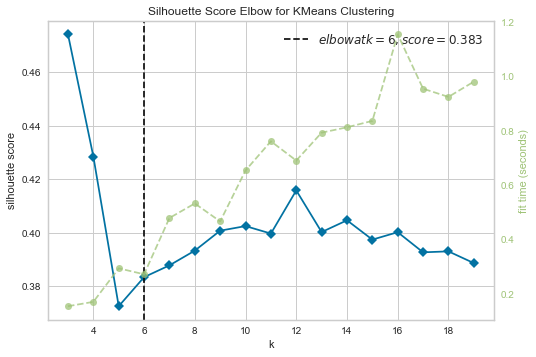

In [9]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), metric='silhouette')
visualizer.fit(df_coordinates[['pickup_longitude', 'pickup_latitude']])
visualizer.poof()

In [233]:
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(3,20), metric='distortion')
# visualizer.fit(df_coordinates[['pickup_longitude', 'pickup_latitude']])
# visualizer.poof()

In [234]:
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(3,20), metric='calinski_harabasz')
# visualizer.fit(df_coordinates[['pickup_longitude', 'pickup_latitude']])
# visualizer.poof()

Apply the optimal number of clusters to the model for pickups

In [235]:
kmeans = KMeans(n_clusters=6, random_state=8)
neighbourhood_clusters = kmeans.fit(df_coordinates[['pickup_longitude', 'pickup_latitude']])

In [236]:
unique, counts = np.unique(neighbourhood_clusters.labels_, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([2879, 1551,  246, 2588,  738, 1333]))

In [237]:
df_coordinates['pickup_neighbourhood'] = neighbourhood_clusters.labels_

In [238]:
df_coordinates.pickup_neighbourhood.value_counts()

0    2879
3    2588
1    1551
5    1333
4     738
2     246
Name: pickup_neighbourhood, dtype: int64

Plot results:

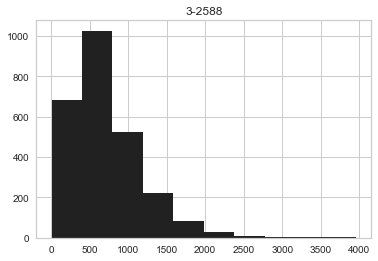

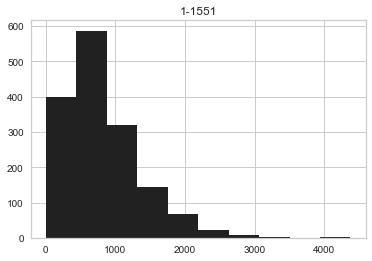

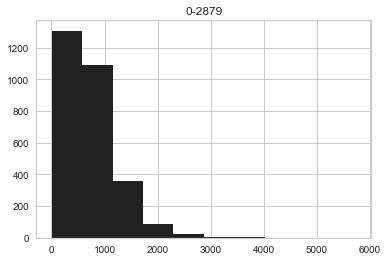

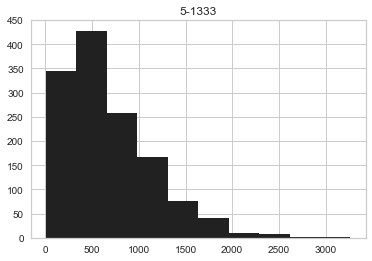

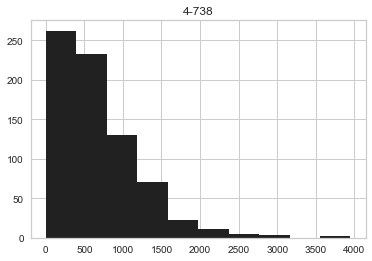

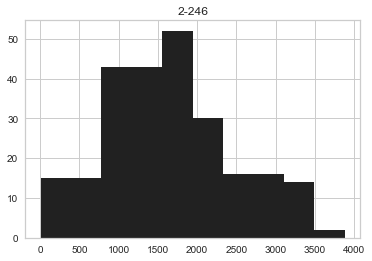

In [239]:
for cluster in df_coordinates.pickup_neighbourhood.unique():
    df_coordinates[df_coordinates['pickup_neighbourhood']==cluster].trip_duration.hist()
    plt.title(str(cluster) + "-" + str(df_coordinates[df_coordinates['pickup_neighbourhood']==cluster].shape[0]))
    plt.show()

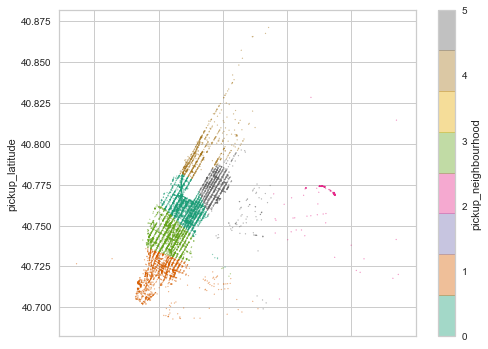

In [240]:
df_coordinates.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4, 
                      figsize=(8,6), s = 1, c ='pickup_neighbourhood', cmap=plt.get_cmap('Dark2'))

Do the clustering for dropoff

In [241]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), metric='silhouette')
visualizer.fit(df_coordinates[['dropoff_longitude', 'dropoff_latitude']])
visualizer.poof()

KeyboardInterrupt: 

In [242]:
kmeans = KMeans(n_clusters=6, random_state=8)
neighbourhood_clusters = kmeans.fit(df_coordinates[['dropoff_longitude', 'dropoff_latitude']])

In [243]:
df_coordinates['dropoff_neighbourhood'] = neighbourhood_clusters.labels_

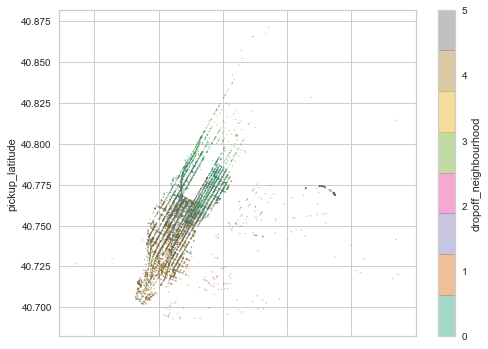

In [244]:
df_coordinates.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4, 
                      figsize=(8,6), s = 1, c ='dropoff_neighbourhood', cmap=plt.get_cmap('Dark2'))

### Further cleaning & data engineering for 2nd clustering

Drop store_and_fwd_flag & vendor_id columns as they are not significant for the clustering, and drop all latitude & longitude information as it's now represented by the cluster information

In [245]:
df_datetime = df_coordinates.copy()

In [246]:
# df_datetime.drop(['store_and_fwd_flag', 'vendor_id', 'pickup_longitude', 'pickup_latitude',
#                'dropoff_longitude', 'dropoff_latitude', 'trip_duration'], inplace=True, axis=1)
df_datetime.drop(['id','store_and_fwd_flag', 'vendor_id', 'pickup_longitude', 'pickup_latitude',
               'dropoff_longitude', 'dropoff_latitude', 'trip_duration'], inplace=True, axis=1)

In [247]:
df_datetime.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_neighbourhood,dropoff_neighbourhood
542490,2016-04-05 19:54:51,2016-04-05 20:00:09,1,3,4
612480,2016-06-18 23:43:31,2016-06-18 23:51:28,1,1,4
1455416,2016-02-23 09:46:31,2016-02-23 10:05:43,1,0,5
117561,2016-03-03 17:31:38,2016-03-03 17:54:55,4,3,5
821676,2016-05-03 11:37:00,2016-05-03 11:43:47,1,1,4


Feature engineering on datetime: convert pick up and drop off dates to datetime

In [248]:
def get_data(dt):
    return [dt.month_name(), dt.day_name(), dt.hour]

df_datetime['pickup'] = df_datetime.pickup_datetime.map(get_data)
df_datetime['dropoff'] = df_datetime.pickup_datetime.map(get_data)

In [249]:
df_datetime.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_neighbourhood,dropoff_neighbourhood,pickup,dropoff
542490,2016-04-05 19:54:51,2016-04-05 20:00:09,1,3,4,"[April, Tuesday, 19]","[April, Tuesday, 19]"
612480,2016-06-18 23:43:31,2016-06-18 23:51:28,1,1,4,"[June, Saturday, 23]","[June, Saturday, 23]"
1455416,2016-02-23 09:46:31,2016-02-23 10:05:43,1,0,5,"[February, Tuesday, 9]","[February, Tuesday, 9]"
117561,2016-03-03 17:31:38,2016-03-03 17:54:55,4,3,5,"[March, Thursday, 17]","[March, Thursday, 17]"
821676,2016-05-03 11:37:00,2016-05-03 11:43:47,1,1,4,"[May, Tuesday, 11]","[May, Tuesday, 11]"


In [250]:
df_datetime.drop(['pickup_datetime', 'dropoff_datetime'], inplace=True, axis=1)

In [251]:
column_names = ['pickup_month', 'pickup_day', 'pickup_hour']

for i in range(len(column_names)):
    df_datetime[column_names[i]] = [x[i] for x in df_datetime['pickup']]

In [252]:
column_names = ['dropoff_month', 'dropoff_day', 'dropoff_hour']

for i in range(len(column_names)):
    df_datetime[column_names[i]] = [x[i] for x in df_datetime['dropoff']]

In [253]:
df_datetime.drop(['pickup', 'dropoff'], inplace=True, axis=1)
df_datetime.head()

,passenger_count,pickup_neighbourhood,dropoff_neighbourhood,pickup_month,pickup_day,pickup_hour,dropoff_month,dropoff_day,dropoff_hour
542490,1,3,4,April,Tuesday,19,April,Tuesday,19
612480,1,1,4,June,Saturday,23,June,Saturday,23
1455416,1,0,5,February,Tuesday,9,February,Tuesday,9
117561,4,3,5,March,Thursday,17,March,Thursday,17
821676,1,1,4,May,Tuesday,11,May,Tuesday,11


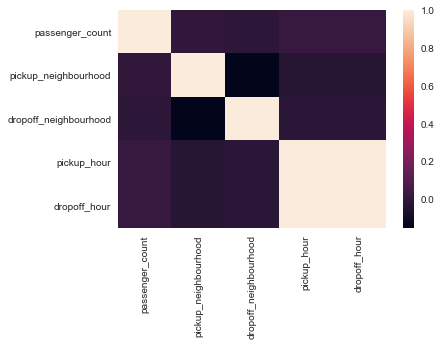

In [254]:
sns.heatmap(df_datetime.corr())

While pickup & drop off are highly correlated, as we're trying to cluster based on trip duration, we will keep this information. We will drop pick up & drop off datetime as we now have the month, hour & day columns

Plot trips by day

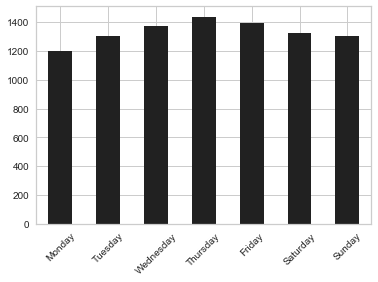

In [255]:
days_grouped = df_datetime.groupby(['pickup_day']).count().passenger_count.reset_index()
weekdays = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = days_grouped['pickup_day'].map(mapping)    
days_grouped = days_grouped.iloc[key.argsort()]

ax = days_grouped.plot(kind='bar', x='pickup_day', legend = False, color=["#212121","#ffb700"])
ax.set_xticklabels(labels=weekdays, rotation=45)
ax.patch.set_facecolor('white')
plt.xlabel("")
plt.show()

Plot trips by hour

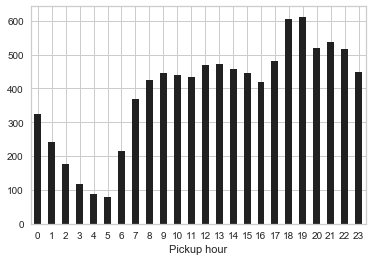

In [256]:
h_grouped = df_datetime.groupby(['pickup_hour']).count().passenger_count.reset_index()
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
mapping = {hour: i for i, hour in enumerate(hours)}
key = h_grouped['pickup_hour'].map(mapping)    
h_grouped = h_grouped.iloc[key.argsort()]

ax = h_grouped.plot(kind='bar', x='pickup_hour', legend = False, color=["#212121","#ffb700"])
ax.xaxis.set_tick_params(rotation=0)
ax.patch.set_facecolor('white')
plt.xlabel("Pickup hour")
plt.show()

Plot pickup hours for working days vs weekend

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


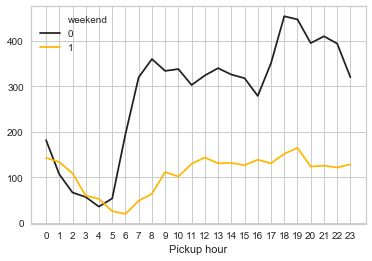

In [257]:
week_vs_wkd = df_datetime[['pickup_day', 'pickup_hour', 'passenger_count']]
week_vs_wkd['weekend'] = np.where(week_vs_wkd.pickup_day == 'Saturday', 1, 
                                  np.where(week_vs_wkd.pickup_day == 'Sunday', 1, 0))
h_grouped = week_vs_wkd.groupby(['weekend', 'pickup_hour']).count().passenger_count.reset_index()

hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
mapping = {hour: i for i, hour in enumerate(hours)}
key = h_grouped['pickup_hour'].map(mapping)    
h_grouped = h_grouped.iloc[key.argsort()]

colors = ["#212121","#ffb700"]
sns.set_palette(sns.color_palette(colors))
ax = sns.lineplot(x="pickup_hour", y="passenger_count", hue="weekend", data=h_grouped)
plt.xlabel("Pickup hour")
plt.ylabel("")
ax.patch.set_facecolor('white')
ax.set_xticks(range(0,24))
plt.show()

See if need to add weekend column

In [258]:
# taxi_drop['weekend'] = np.where(taxi_drop.pickup_day == 'Saturday', 1, 
#                                   np.where(taxi_drop.pickup_day == 'Sunday', 1, 0))

Create labels of the day to put hours in 4 bins

In [259]:
day_labels = ['night', 'morning', 'afternoon', 'evening']
cutoffs = [-1, 5, 11, 17, 23]
df_datetime['pickup_timeofday'] = pd.cut(df_datetime['pickup_hour'], cutoffs, labels=day_labels)
df_datetime['dropoff_timeofday'] = pd.cut(df_datetime['dropoff_hour'], cutoffs, labels=day_labels)

In [260]:
df_datetime.drop(['pickup_hour', 'dropoff_hour'], inplace=True, axis=1)

In [261]:
df_datetime.head()

,passenger_count,pickup_neighbourhood,dropoff_neighbourhood,pickup_month,pickup_day,dropoff_month,dropoff_day,pickup_timeofday,dropoff_timeofday
542490,1,3,4,April,Tuesday,April,Tuesday,evening,evening
612480,1,1,4,June,Saturday,June,Saturday,evening,evening
1455416,1,0,5,February,Tuesday,February,Tuesday,morning,morning
117561,4,3,5,March,Thursday,March,Thursday,afternoon,afternoon
821676,1,1,4,May,Tuesday,May,Tuesday,morning,morning


Do one hot encoding on day, time of day & neigbourhood fields to transform the categorical variable

In [262]:
df_dummies = pd.get_dummies(data=df_datetime, columns=['pickup_neighbourhood', 'dropoff_neighbourhood',
                                                     'pickup_month', 'pickup_day', 'dropoff_month', 
                                                     'dropoff_day', 'pickup_timeofday','dropoff_timeofday'])

In [301]:
df_dummies.shape

(9335, 47)

### K-Means Clustering

Do further clustering for the new dataset to search for clusters based on pickup & dropoff time/day

Use elbow curve for cluster number

In [321]:
df_ML = df_dummies.copy()

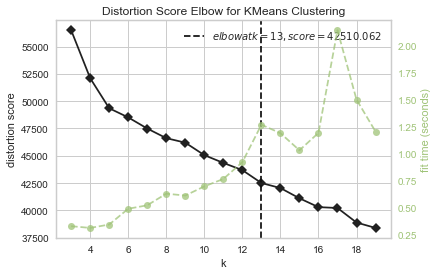

In [154]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), metric='distortion') #distortion=inertia
visualizer.fit(df_ML)
visualizer.poof()

In [322]:
kmeans = KMeans(n_clusters=5)
taxi_clusters = kmeans.fit(df_ML)
labels =taxi_clusters.predict(df_ML)

In [323]:
df_ML['final_clusters'] = taxi_clusters.labels_

In [324]:
from sklearn.metrics import silhouette_score 

X_cols = [col for col in df_ML.columns if col != 'final_clusters']
X = df_ML[X_cols]

score = silhouette_score(X, labels, metric='euclidean')
score

0.16416385920258025

In [325]:
df['final_clusters'] = taxi_clusters.labels_

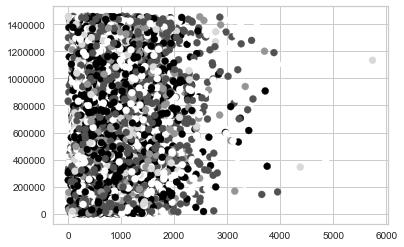

In [329]:
plt.scatter(df.trip_duration, df.index, c = df.final_clusters) 

Try scaling, normalizing & PCA

In [332]:
df_ML2 = df_dummies.copy()

In [333]:
# Scaling the data to bring all the attributes to a comparable level 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 

scaler = StandardScaler() 
X_scaled = scaler.fit_transform(df_ML2) 
  
# Normalizing the data so that  
# the data approximately follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [334]:
#Reducing the dimensionality of the data to make it visualizable
from sklearn.decomposition import PCA 

pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

In [335]:
kmeans = KMeans(n_clusters=4)
taxi_clusters = kmeans.fit(X_principal)
labels =taxi_clusters.predict(X_principal)

In [336]:
X_principal['final_clusters'] = taxi_clusters.labels_

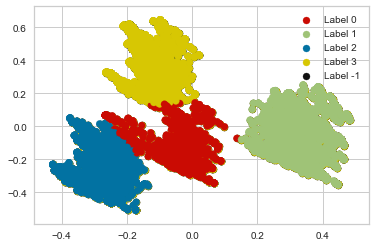

In [337]:
# Visualizing the clustering

# Building the label to colour mapping 
colours = {} 
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[-1] = 'k'
colours[3] = 'y'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels] 
  
# For the construction of the legend of the plot 
r = plt.scatter(X_principal['P1'], X_principal['P2'], color ='r'); 
g = plt.scatter(X_principal['P1'], X_principal['P2'], color ='g'); 
b = plt.scatter(X_principal['P1'], X_principal['P2'], color ='b'); 
k = plt.scatter(X_principal['P1'], X_principal['P2'], color ='k'); 
y = plt.scatter(X_principal['P1'], X_principal['P2'], color ='y'); 

# Plotting P1 on the X-Axis and P2 on the Y-Axis  
# according to the colour vector defined 
# plt.figure(figsize =(9, 9)) 
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec) 
  
# Building the legend 
plt.legend((r, g, b, y, k), ('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label -1')) 
  
plt.show() 

### DBscan

In [277]:
df_ML3 = df_dummies.copy()

In [278]:
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(df_ML3) 
X_normalized = normalize(X_scaled) 
X_normalized = pd.DataFrame(X_normalized) 

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [279]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

In [280]:
# Building the clustering model
from sklearn.cluster import DBSCAN 

db_default = DBSCAN(eps = 0.0375, min_samples = 3).fit(X_principal) 
labels = db_default.labels_

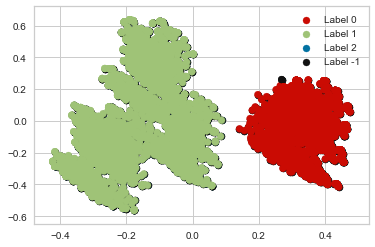

In [281]:
# Visualizing the clustering

# Building the label to colour mapping 
colours = {} 
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[-1] = 'k'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels] 
  
# For the construction of the legend of the plot 
r = plt.scatter(X_principal['P1'], X_principal['P2'], color ='r'); 
g = plt.scatter(X_principal['P1'], X_principal['P2'], color ='g'); 
b = plt.scatter(X_principal['P1'], X_principal['P2'], color ='b'); 
k = plt.scatter(X_principal['P1'], X_principal['P2'], color ='k'); 
  
# Plotting P1 on the X-Axis and P2 on the Y-Axis  
# according to the colour vector defined 
# plt.figure(figsize =(9, 9)) 
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec) 
  
# Building the legend 
plt.legend((r, g, b, k), ('Label 0', 'Label 1', 'Label 2', 'Label -1')) 
  
plt.show() 

### Hierarchical clustering

In [138]:
df_ML3 = df_dummies.copy()

In [130]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

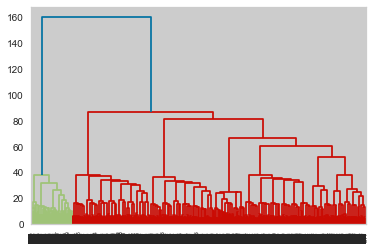

In [139]:
dendrogram = sch.dendrogram(sch.linkage(df_ML3, method='ward'))

### Gaussian Mixture

In [282]:
df_ML4 = df_dummies.copy()

In [287]:
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(df_ML4) 
X_normalized = normalize(X_scaled) 
X_normalized = pd.DataFrame(X_normalized) 

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [290]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
X_principal.head()

,P1,P2
0,0.411897,-0.101108
1,0.460033,-0.211034
2,-0.170697,0.455151
3,-0.295825,-0.034221
4,-0.109884,0.367863


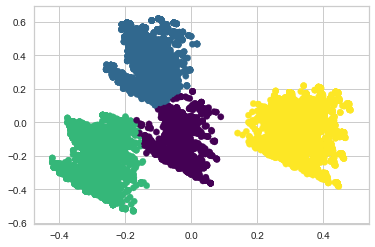

In [291]:
from sklearn import mixture 
gmm = mixture.GaussianMixture(n_components=4).fit(X_principal)
labels = gmm.predict(X_principal)

plt.scatter(X_principal.P1 , X_principal.P2, c=labels, s=40, cmap='viridis');

In [293]:
score = silhouette_score(X_principal, labels, metric='euclidean')
score

0.5468850218683641